In [ ]:
import tensorflow as tf
tf.__version__ 

'2.11.0'

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
train_Path = '/content/drive/MyDrive/images/train'
test_Path = '/content/drive/MyDrive/images/test'
IMAGE_SIZE = [224, 224]

In [ ]:
resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], 
    weights = 'imagenet', 
    include_top = False  
)

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
folders = glob(train_Path + '/*')
folders

['/content/drive/MyDrive/images/train/LSD',
 '/content/drive/MyDrive/images/train/IBK',
 '/content/drive/MyDrive/images/train/FMD']

In [ ]:
car_label = ['FMD', 'LSD', 'IBK']

In [ ]:
x = Flatten() (resnet.output)

In [ ]:
prediction = Dense(len(folders), activation = 'softmax')(x)

In [ ]:
model = Model(inputs = resnet.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy',precision_m,recall_m,f1_m]
)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
training_set = train_datagen.flow_from_directory(
    train_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical'
)

Found 5752 images belonging to 3 classes.


In [ ]:
test_set = train_datagen.flow_from_directory(
    test_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1435 images belonging to 3 classes.


In [ ]:
history = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 20,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

Epoch 1/20
180/180 [==============================] - 965s 5s/step - loss: 2.3265 - accuracy: 0.7563 - precision_m: 0.7768 - recall_m: 0.7264 - f1_m: 0.7500 - val_loss: 2.6137 - val_accuracy: 0.2976 - val_precision_m: 0.2981 - val_recall_m: 0.2953 - val_f1_m: 0.2967
Epoch 2/20
180/180 [==============================] - 147s 815ms/step - loss: 0.2245 - accuracy: 0.9270 - precision_m: 0.9319 - recall_m: 0.9206 - f1_m: 0.9261 - val_loss: 1.1317 - val_accuracy: 0.3470 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/20
180/180 [==============================] - 128s 710ms/step - loss: 0.0961 - accuracy: 0.9701 - precision_m: 0.9716 - recall_m: 0.9689 - f1_m: 0.9702 - val_loss: 34.3442 - val_accuracy: 0.3429 - val_precision_m: 0.3428 - val_recall_m: 0.3428 - val_f1_m: 0.3428
Epoch 4/20
180/180 [==============================] - 147s 817ms/step - loss: 0.1287 - accuracy: 0.9656 - precision_m: 0.9665 - recall_m: 0.9642 - f1_m: 0.9653 - val_loss: 17.9742 

In [ ]:

metrics_train = model.evaluate(training_set)
metrics_test = model.evaluate(test_set)

print(f"TRAIN_SET: {metrics_train}")
print("--------------------------------------------")
print(f"TEST_SET: {metrics_test}")

45/45 [==============================] - 23s 517ms/step - loss: 0.7194 - accuracy: 0.9122 - precision_m: 0.9121 - recall_m: 0.9121 - f1_m: 0.9121
TRAIN_SET: [0.4983283579349518, 0.9221140742301941, 0.9223118424415588, 0.9217013716697693, 0.9220017194747925]
--------------------------------------------
TEST_SET: [0.7194288969039917, 0.9121951460838318, 0.9121142029762268, 0.9121142029762268, 0.912114143371582]


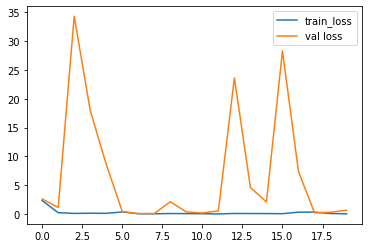

In [ ]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()

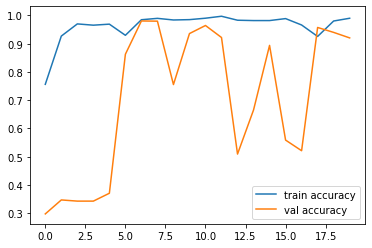

In [ ]:
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.plot(history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()

In [ ]:
prediction = model.predict(test_set)

45/45 [==============================] - 24s 503ms/step


In [ ]:
prediction

array([[9.9999988e-01, 1.6400368e-07, 4.2321644e-17],
       [2.1556389e-08, 1.1936101e-16, 1.0000000e+00],
       [4.4365477e-21, 1.0000000e+00, 0.0000000e+00],
       ...,
       [9.9991763e-01, 8.2413659e-05, 1.2200450e-09],
       [2.3803099e-04, 1.8120964e-08, 9.9976200e-01],
       [9.9691988e-10, 9.6354822e-17, 1.0000000e+00]], dtype=float32)